In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
TRAIN_PATH = os.path.join("data", "postprocessed","training", "TRAIN_CLEAN.parquet")
df = pd.read_parquet(TRAIN_PATH)

In [19]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ==== CONFIG ====
TRAIN_PATH = os.path.join("data", "postprocessed", "training", "TRAIN_CLEAN.parquet")
DATA_PATH = Path(TRAIN_PATH)  # can be a single file or a directory

# Columns we expect in the fuel parquet files
COLUMNS = [
    "flight_id",
    "typecode",
    "source",
    "fuel_kg",
    "dev_start_s",
    "dev_end_s",
    "start",
    "end",
    "duration_s",
    "latitude_mean",
    "latitude_delta",
    "longitude_mean",
    "longitude_delta",
    "altitude_mean",
    "altitude_delta",
    "groundspeed_mean",
    "groundspeed_delta",
    "track_mean",
    "track_delta",
    "vertical_rate_mean",
    "vertical_rate_delta",
    "mach_mean",
    "mach_delta",
]


# ---------- LOADING & FEATURE ENGINEERING ----------

def load_parquet_fuel(path: Path) -> pd.DataFrame:
    """
    Load fuel data from either:
      - a single parquet file, or
      - all parquet files in a folder.

    Keeps only the expected columns and concatenates if needed.
    """
    path = Path(path)

    # Case 1: single file
    if path.is_file():
        print(f"Reading single parquet file: {path}")
        df = pd.read_parquet(path)

        missing = [c for c in COLUMNS if c not in df.columns]
        if missing:
            raise ValueError(f"Missing required columns in file {path}: {missing}")

        df = df[COLUMNS].copy()

    # Case 2: directory of files
    else:
        dfs = []
        files = sorted(path.glob("*.parquet"))
        if not files:
            raise FileNotFoundError(f"No .parquet files found in {path}")

        for f in files:
            print(f"Reading {f.name} ...")
            df_f = pd.read_parquet(f)

            missing = [c for c in COLUMNS if c not in df_f.columns]
            if missing:
                print(f"  -> skipping {f.name}, missing columns: {missing}")
                continue

            df_f = df_f[COLUMNS].copy()
            dfs.append(df_f)

        if not dfs:
            raise ValueError("No usable parquet files found (all missing required columns).")

        df = pd.concat(dfs, ignore_index=True)

    # parse datetimes
    df["start"] = pd.to_datetime(df["start"])
    df["end"] = pd.to_datetime(df["end"])

    return df


def add_fuel_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add derived fuel-related features on a copy of df.
    Assumes duration_s in seconds, groundspeed_mean in knots.
    """
    df = df.copy()

    # avoid division by zero
    duration_h = df["duration_s"].astype(float).replace(0, np.nan) / 3600.0
    duration_min = df["duration_s"].astype(float).replace(0, np.nan) / 60.0

    # basic fuel rates
    df["fuel_flow_kg_per_h"] = df["fuel_kg"] / duration_h
    df["fuel_per_min"] = df["fuel_kg"] / duration_min

    # approximate distance flown in each segment (nautical miles)
    # 1 kt = 1 NM / hour
    df["distance_nm"] = df["groundspeed_mean"] * duration_h
    df["fuel_per_nm"] = df["fuel_kg"] / df["distance_nm"]

    # mid-time of the segment for nicer time plots
    df["mid_time"] = df["start"] + (df["end"] - df["start"]) / 2

    # simple phase-of-flight classification from vertical rate
    climb_thr = 300.0    # ft/min
    desc_thr = -300.0    # ft/min

    df["phase"] = "cruise"
    df.loc[df["vertical_rate_mean"] > climb_thr, "phase"] = "climb"
    df.loc[df["vertical_rate_mean"] < desc_thr, "phase"] = "descent"

    # altitude bands
    alt_bins = [0, 10000, 20000, 30000, 40000, 50000]
    alt_labels = ["<10k", "10–20k", "20–30k", "30–40k", "40–50k"]
    df["alt_band"] = pd.cut(
        df["altitude_mean"],
        bins=alt_bins,
        labels=alt_labels,
        include_lowest=True
    )

    return df


# ---------- PLOTTING HELPERS ----------

def plot_fuel_distributions(df: pd.DataFrame):
    """Histograms of direct fuel quantities and rates (counts on y-axis)."""
    vars_hist = [
        ("fuel_kg", "Fuel per segment [kg]"),
        ("fuel_flow_kg_per_h", "Fuel flow [kg/h]"),
        ("fuel_per_nm", "Fuel per NM [kg/NM]"),
        ("fuel_per_min", "Fuel per minute [kg/min]"),
    ]

    for col, label in vars_hist:
        plt.figure(figsize=(8, 4))
        x = df[col].dropna()
        plt.hist(x, bins=200)
        plt.title(f"Histogram of {label}")
        plt.xlabel(label)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


def plot_fuel_vs_drivers(df: pd.DataFrame):
    """Scatter / relationship plots fuel vs. key drivers."""
    # fuel vs duration
    plt.figure(figsize=(6, 4))
    plt.scatter(df["duration_s"] / 60.0, df["fuel_kg"], s=5, alpha=0.3)
    plt.xlabel("Segment duration [min]")
    plt.ylabel("Fuel per segment [kg]")
    plt.title("Fuel vs Segment Duration")
    plt.tight_layout()
    plt.show()

    # fuel flow vs altitude
    plt.figure(figsize=(6, 4))
    plt.scatter(df["altitude_mean"], df["fuel_flow_kg_per_h"], s=5, alpha=0.3)
    plt.xlabel("Altitude mean [ft]")
    plt.ylabel("Fuel flow [kg/h]")
    plt.title("Fuel flow vs Altitude")
    plt.tight_layout()
    plt.show()

    # fuel flow vs Mach
    if df["mach_mean"].notna().any():
        plt.figure(figsize=(6, 4))
        plt.scatter(df["mach_mean"], df["fuel_flow_kg_per_h"], s=5, alpha=0.3)
        plt.xlabel("Mach mean [-]")
        plt.ylabel("Fuel flow [kg/h]")
        plt.title("Fuel flow vs Mach")
        plt.tight_layout()
        plt.show()

    # fuel per NM vs altitude
    plt.figure(figsize=(6, 4))
    plt.scatter(df["altitude_mean"], df["fuel_per_nm"], s=5, alpha=0.3)
    plt.xlabel("Altitude mean [ft]")
    plt.ylabel("Fuel per NM [kg/NM]")
    plt.title("Fuel per NM vs Altitude")
    plt.tight_layout()
    plt.show()


def plot_fuel_by_phase_and_altband(df: pd.DataFrame):
    """Boxplots of fuel flow by phase-of-flight and by altitude band."""
    # phase-of-flight
    plt.figure(figsize=(6, 4))
    df_box = df[["phase", "fuel_flow_kg_per_h"]].dropna()
    df_box.boxplot(by="phase", column="fuel_flow_kg_per_h")
    plt.suptitle("")
    plt.title("Fuel flow [kg/h] by phase-of-flight")
    plt.xlabel("Phase")
    plt.ylabel("Fuel flow [kg/h]")
    plt.tight_layout()
    plt.show()

    # altitude band
    if df["alt_band"].notna().any():
        plt.figure(figsize=(6, 4))
        df_box2 = df[["alt_band", "fuel_per_nm"]].dropna()
        df_box2.boxplot(by="alt_band", column="fuel_per_nm")
        plt.suptitle("")
        plt.title("Fuel per NM [kg/NM] by altitude band")
        plt.xlabel("Altitude band [ft]")
        plt.ylabel("Fuel per NM [kg/NM]")
        plt.tight_layout()
        plt.show()


def plot_time_based(df: pd.DataFrame):
    """
    Time-based views using segment start times and daily totals.
    """
    df_ts = df.sort_values("start")

    # fuel per segment over chronological time
    plt.figure(figsize=(12, 4))
    plt.plot(df_ts["start"], df_ts["fuel_kg"], linewidth=0.5)
    plt.xlabel("Segment start time")
    plt.ylabel("Fuel per segment [kg]")
    plt.title("Fuel per segment over time (all flights)")
    plt.tight_layout()
    plt.show()

    # daily total fuel (rough sanity check)
    daily_fuel = df_ts.groupby(df_ts["start"].dt.date)["fuel_kg"].sum()

    plt.figure(figsize=(10, 4))
    plt.plot(daily_fuel.index, daily_fuel.values, linewidth=1)
    plt.xlabel("Date")
    plt.ylabel("Total fuel [kg/day]")
    plt.title("Daily total fuel (all flights)")
    plt.tight_layout()
    plt.show()


# ---------- DRIVER FUNCTION ----------

def analyze_fuel(path: Path):
    """
    End-to-end: load parquet fuel data (file or folder), engineer features,
    print stats, and generate all plots.
    """
    df_raw = load_parquet_fuel(path)
    df = add_fuel_features(df_raw)

    print("\n=== Summary statistics (key fuel metrics) ===")
    print(
        df[
            [
                "fuel_kg",
                "fuel_flow_kg_per_h",
                "fuel_per_nm",
                "fuel_per_min",
                "altitude_mean",
                "groundspeed_mean",
                "mach_mean",
            ]
        ].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
    )

    plot_fuel_distributions(df)
    plot_fuel_vs_drivers(df)
    plot_fuel_by_phase_and_altband(df)
    plot_time_based(df)


# In your notebook / script:
# analyze_fuel(DATA_PATH)


Reading single parquet file: data\postprocessed\training\TRAIN_CLEAN.parquet

=== Summary statistics (key fuel metrics) ===
             fuel_kg  fuel_flow_kg_per_h    fuel_per_nm   fuel_per_min  \
count  131530.000000       131530.000000  118666.000000  131530.000000   
mean      557.705484         3354.816981       7.864975      55.913616   
std       883.558032         2739.599780       9.255299      45.659996   
min         0.453592           35.620499       0.153047       0.593675   
1%         16.329312          330.604194       1.039442       5.510070   
5%         45.359200          544.915256       1.457961       9.081921   
50%       200.000000         2400.728221       5.533645      40.012137   
95%      2200.000000         7454.931736      18.115788     124.248862   
99%      4469.241976        11994.552208      38.540667     199.909203   
max     32205.032000        59368.321064     272.029840     989.472018   

       altitude_mean  groundspeed_mean     mach_mean  
count 

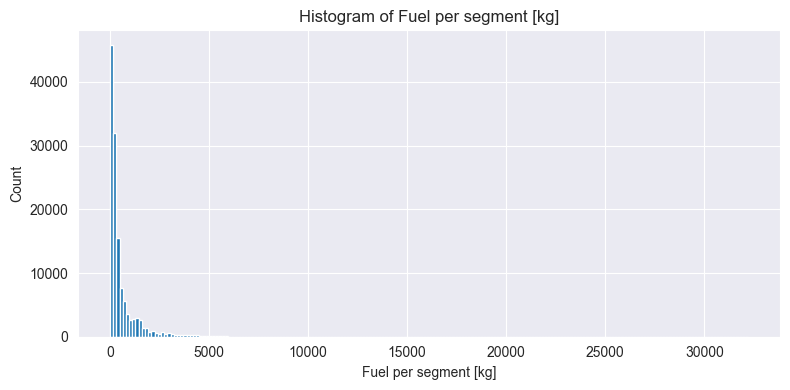

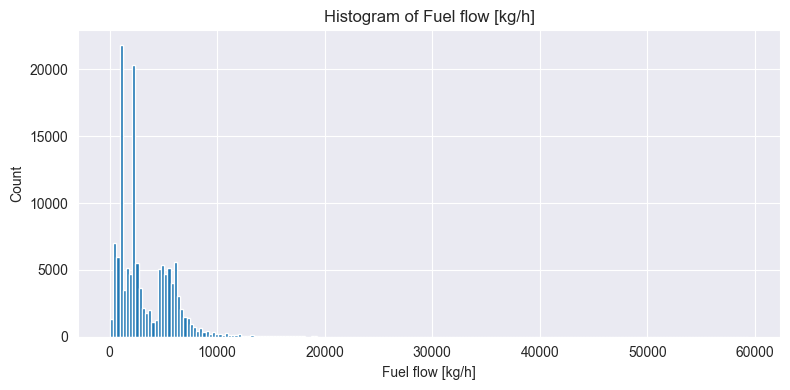

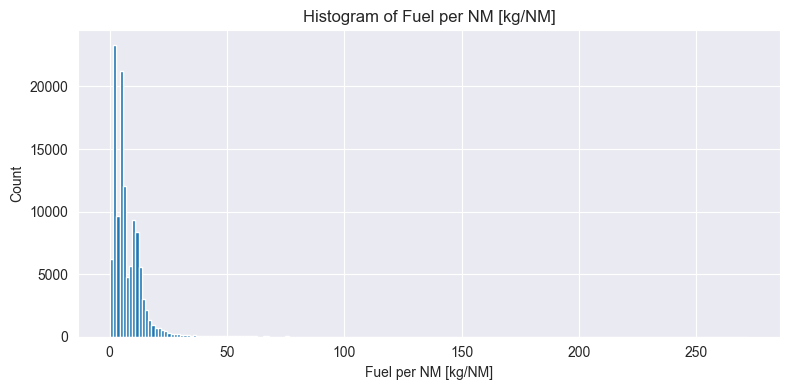

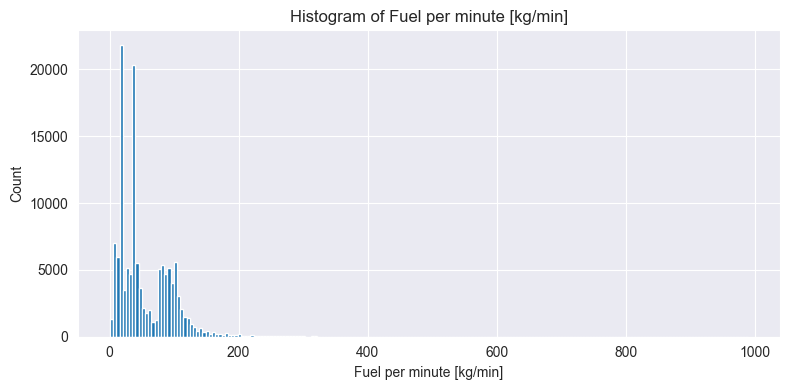

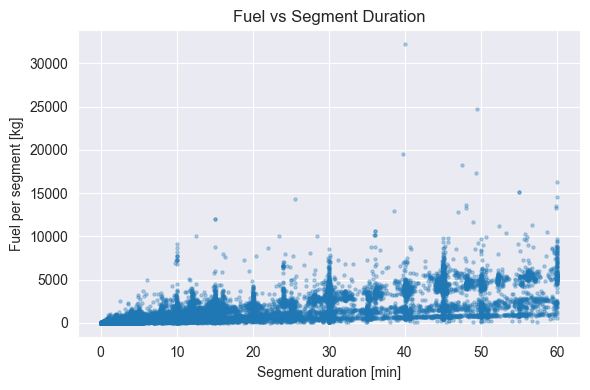

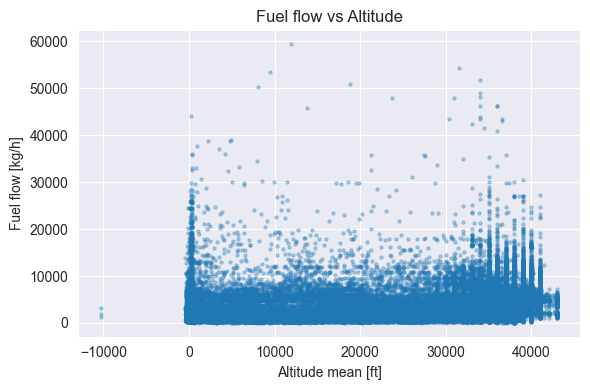

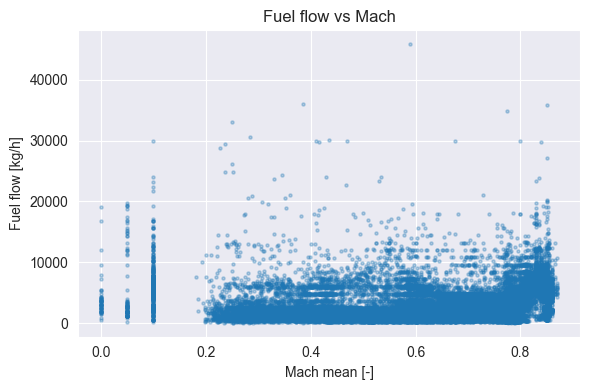

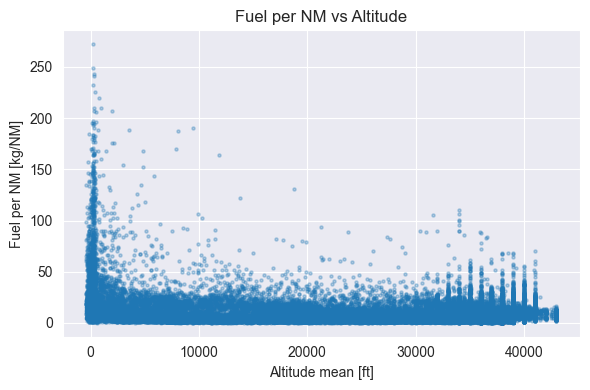

<Figure size 600x400 with 0 Axes>

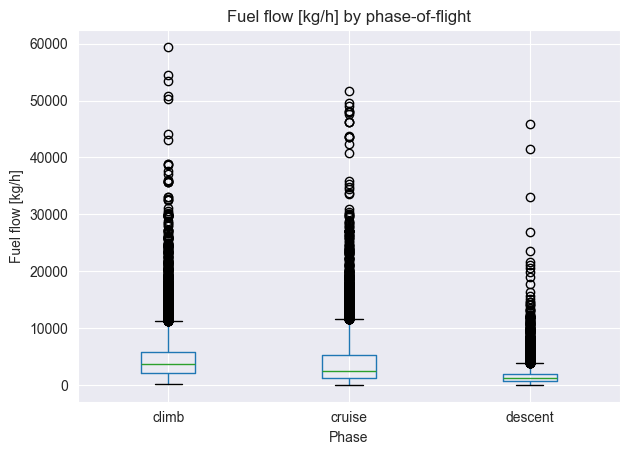

<Figure size 600x400 with 0 Axes>

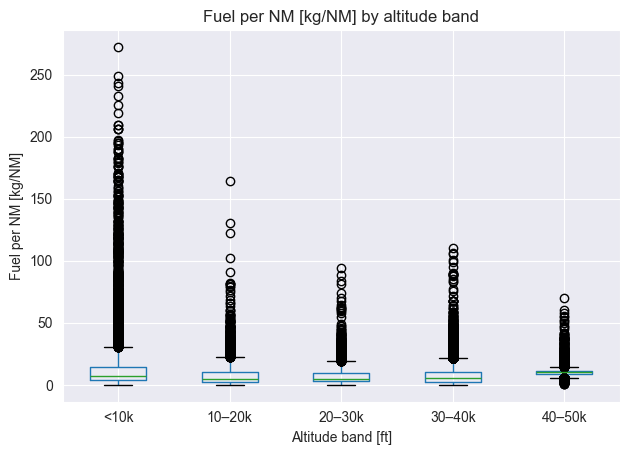

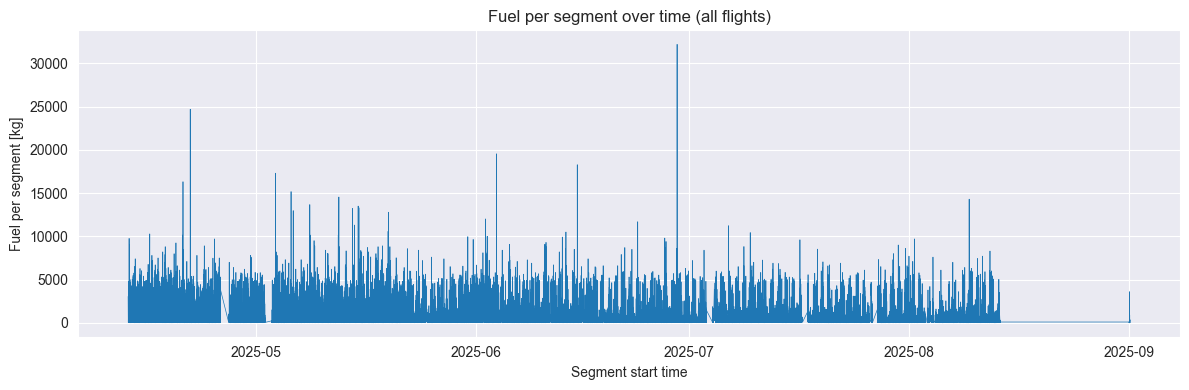

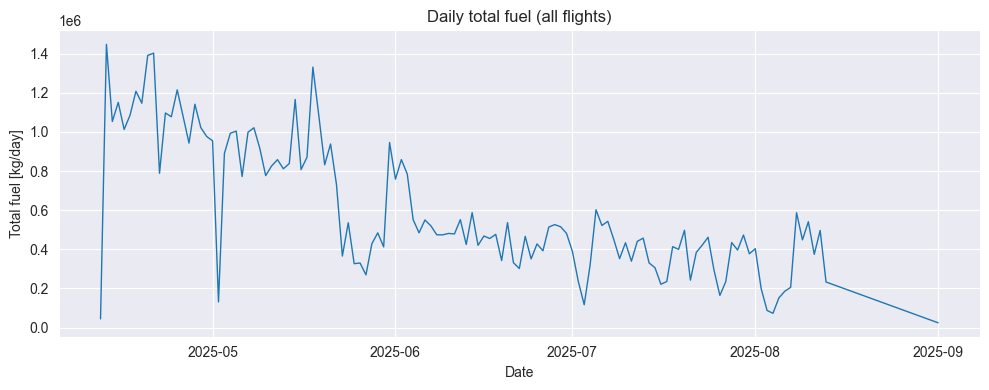

In [21]:
analyze_fuel(TRAIN_PATH)